# Question 1
## Image Transformations

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from src.functions import imread, imshow

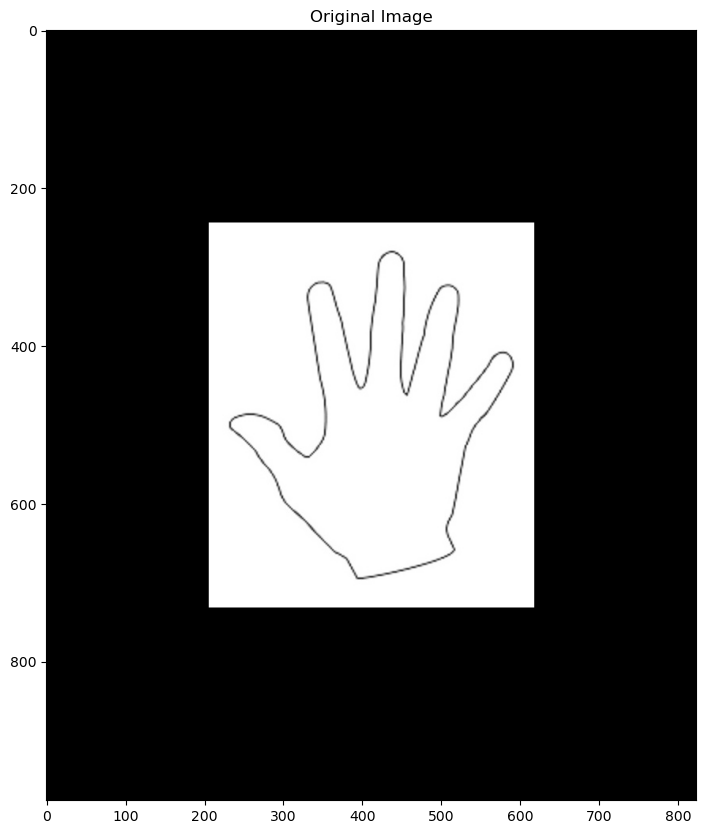

In [2]:
Original_image = imread('images/Original_image.jpg')
imshow(Original_image , "Original Image")

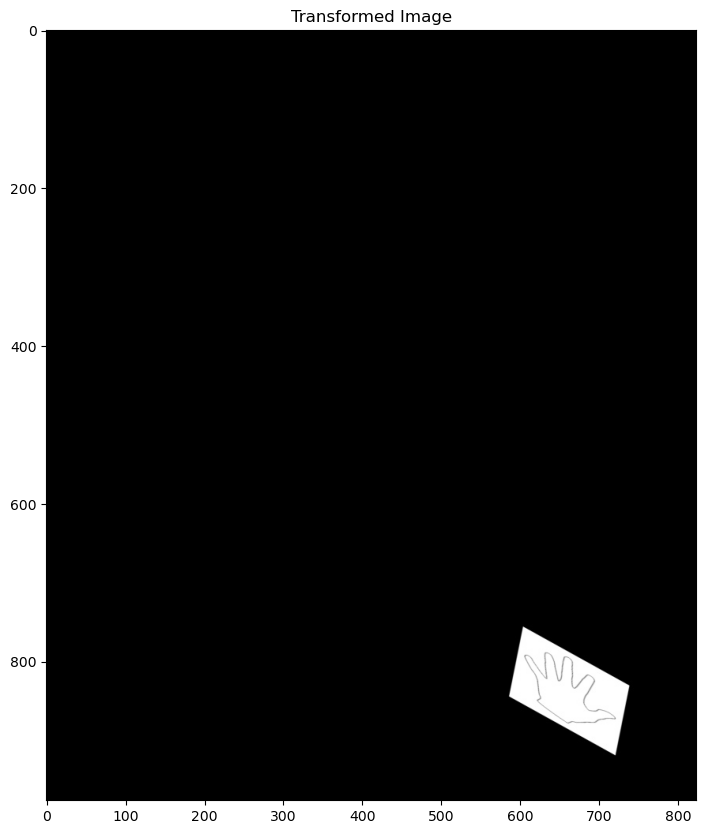

In [3]:
transformed_image = imread('images/transformed_image.jpg')
imshow(transformed_image , "Transformed image")

In [4]:
# TODO: Complete this section